In [1]:
import os

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.pyplot as plt
import matplotlib.cm as com
import numpy as np

from scipy.signal import savgol_filter, find_peaks
from scipy.spatial import distance

from random import shuffle, uniform
import errno

In [2]:
# Standard Brian2 import
from brian2 import *

# Enable GPU usage via Brian2CUDA
import brian2cuda
set_device('cpp_standalone', build_on_run=False)

import matplotlib.pyplot as plt
import os

import time
import pickle


defaultclock.dt = 0.05*ms
clock_dt = defaultclock.dt

%matplotlib inline


In [3]:
include_state_monitor = {}
include_state_monitor['Input'] = False
include_state_monitor['Neurons'] = False
include_state_monitor['Synapses'] = False

In [ ]:
in_rate = 0
vth_ = 0
training_foldername = 'training_output'

Network parameters

Parameters are defined and then each multiplied by its corresponding unit
This is done separately to allow for passing parameters when automating the (training + testing) process with papermill

In [ ]:
## INPUT

N_per_edge = 20                         #number of input neurons per dimension
refract_in = 0                          #input neurons refractory period (ms)
in_zone_d = (1/(N_per_edge-1)) + (1e-6) #distance between two consecutive points 
                                        #in a straight line with N_per_edge 
                                        #equidistant points distributed along the line

## WTA

N_o = 61                                #number of neurons per sensor
resting_time = 50                       #resting time (ms)
V_rest = -65                            #resting potential (mV)
V_reset = -65                           #reset potential (mV)
V_th = {}                           
V_th['Gyroscope'] = vth_                #gyroscope neurons base threshold potential time (mV)
V_th['Accelerometer'] = vth_            #accelerometer neurons base threshold potential time (mV)
tau_r = 10                              #refractory period  (ms)
d_vt = 3.0                              #adaptive threshold increment (mV)
tauvt = 400                             #adaptive threshold decay time constant (ms)
tau_m = 30                              #membrane time constant (ms)
tau_I_m = 5                             #input excitatory current time constant (ms)
tau_I_i = 20                            #input inhibitory current time constant (ms)
R_m = 1                                 #excitatory membrane resistance (ohm)
R_i = 1                                 #inhibitory membrane resistance (ohm)


## INPUT -> WTA (excitatory synapses with trace-based STDP)

taupre = 20.0                       #presynaptic activity trace time constant (ms) 
taupost = 20.0                      #postsynaptic activity trace time constant (ms)
Apre = 0.03                         #maximum weight modification for LTP
Apost = - 1.05 * Apre               #maximum weight modification for LTD

w_e = 20.0                          #excitatory current increment  (mA)
w_i = 1                             #inhibitory current increment  (mA)
wmax = 1.0                          #maximum value of weights between input and wta layer
initial_weight_coef = 0.15          #the weights are initialized randomly with values in [0, initial_weight_coef]


## WTA -> WTA (lateral inhibitory synapses)

tau_inh = 10                        #inhibition duration (ms)

In [5]:
V_rest *= mV
V_reset *= mV
V_th['Gyroscope'] *= mV
V_th['Accelerometer'] *= mV
#V_th *= mV
tau_m *= ms
tau_I_m *= ms
tauvt *= 400
tau_I_i *= ms
R_m *= ohm
R_i *= ohm
w_e *= mA
w_i *= mA
tau_r *= ms
d_vt *= mV
taupre *= ms
taupost *= ms
tau_inh *= ms
refract_in *= ms
resting_time *= ms
in_rate *= Hz


In [6]:
#If any of the flags are set, state monitors will be included in the simulation
#This means that you should run a small trial (with less samples) to ensure that
#the recording data doesn't exceed the available memory in your computer

#n_samples : number of samples per movement for training
#n_reps_per_sample : number of times each sample is shown to the newtwork during training

if include_state_monitor['Input'] or include_state_monitor['Neurons']:
    n_samples = 1
    n_reps_per_sample = 1
else:
    n_samples = 150
    n_reps_per_sample = 1

In [7]:
#Evenly distributed points within a cube
#Used to generate the input neurons coordinates
class Nube:
    i = 0
    def __init__(self, n_nodes):
        self.n = n_nodes**3
        self.neighbour_dst = 2 / (n_nodes - 1)
        
        ps = np.linspace(-1,1,n_nodes)
        self.coordinates = [[[(x_,y_,z_) for z_ in ps] for y_ in ps] for x_ in ps]
        self.coordinates = [item for sublist in self.coordinates for item in sublist]
        self.coordinates = [item for sublist in self.coordinates for item in sublist]
        self.coordinates = {index: pos for index, pos in enumerate(self.coordinates)}
        self.x = [pos[0] for pos in self.coordinates.values()]
        self.y = [pos[1] for pos in self.coordinates.values()]
        self.z = [pos[2] for pos in self.coordinates.values()]

    def scatter_neurons(self, ax):
        for n in range(self.n):
            x_,y_,z_ = self.coordinates[n]
            ax.scatter(x_,y_,z_, alpha = 0.5, c = 'cornflowerblue')
    plt.show()

In [8]:
#Function to load a stream of sensor readings from a .txt file located in Dataset/{MOVEMENT_NAME}
#Structure of each line of the file, which correspond to one reading: gx gy gz ax ay az t 
#g - gyroscope
#a - accelerometer
#t - timestamp
#MOVEMENT_NAME - name of performed movement (check Dataset folder for all the available movements)
def load_trial(dir_):
    
    g_x = []
    g_y = []
    g_z = []
    a_x = []
    a_y = []
    a_z = []
    tt = []

    file1 = open(dir_, 'r')

    lines = file1.readlines()

    for line in lines:
            word = line.split()
            try:
                    g_x.append(float(word[0]))
                    g_y.append(float(word[1]))
                    g_z.append(float(word[2]))
                    a_x.append(float(word[3]))
                    a_y.append(float(word[4]))
                    a_z.append(float(word[5]))
                    tt.append(float(word[6]))
            except:
                    pass
    file1.close()

    sensor_data = [g_x,g_y,g_z, a_x,a_y,a_z,tt] 

    #data = pd.DataFrame([g_x,g_y,g_z, a_x,a_y,a_z])
    #data = data.transpose()
    #data.columns = ['gx', 'gy', 'gz', 'ax', 'ay', 'az']
            
    return [g_x,g_y,g_z, a_x,a_y,a_z,tt] #, data

##Normalize 16-bit signed integeres
def normalize_axis(s_axis):
    
    ret = [[] for s in s_axis]
    
    ret = s_axis.copy()
    
    for a,axis in enumerate(ret):
        for v, value in enumerate(axis):
            
            if ret[a][v] < 0:
                ret[a][v] = ret[a][v]/(32768)    # + 32767)
            else:
                ret[a][v] = ret[a][v]/(32767)   #+ 32768)
    
    return ret
        

In [9]:
dir_ = os.path.join(os.getcwd(), 'Dataset') # dataset directory
n_axis = 6  

In [10]:
sampling_frequency = 100*Hz                 # sensors sampling frequency

The dataset datastreams are segmented into single movement samples
by simply choosing the sensor axis, for each movement, that shows the
most sinosoidal aspect. This axis is filtered. Then the maximum peaks
of the filtered signal are determined and used to segment the samples

Samples will be stored in 'samples'
'samples[m][a]' is a list of lists where each list is a sample for both a movement with index m and an axis with index a

Running in place
85.05263157894737
81.7948717948718
86.57894736842105
85.55263157894737
86.23076923076923
83.97560975609755


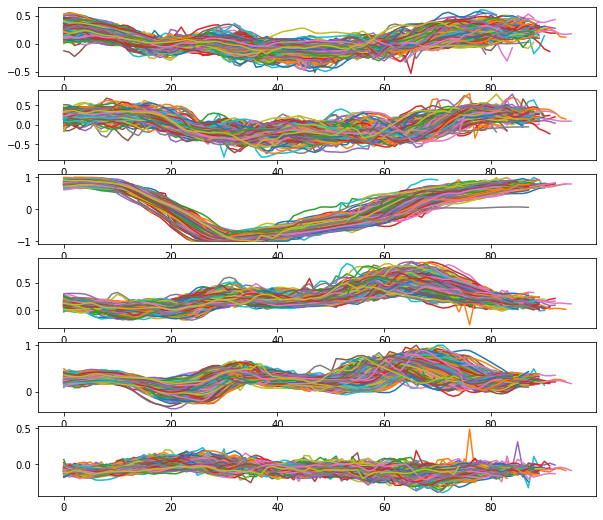

Torso rotation
174.16666666666666
171.5
189.48888888888888
179.28205128205127
179.57894736842104
179.02564102564102


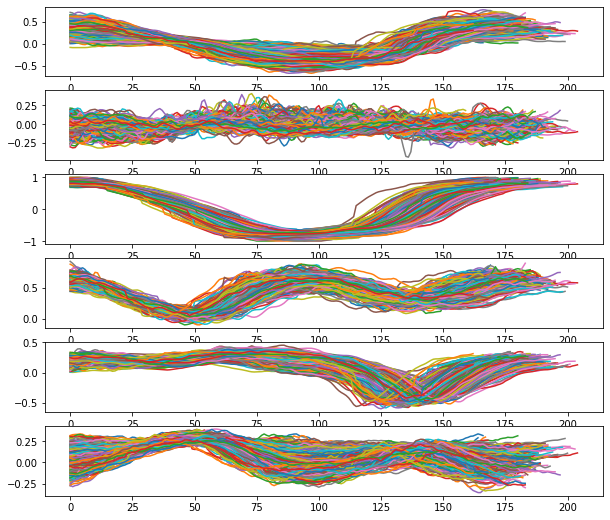

Jumping jacks
89.07894736842105
91.32432432432432
91.70454545454545
92.25
94.10810810810811
93.62162162162163


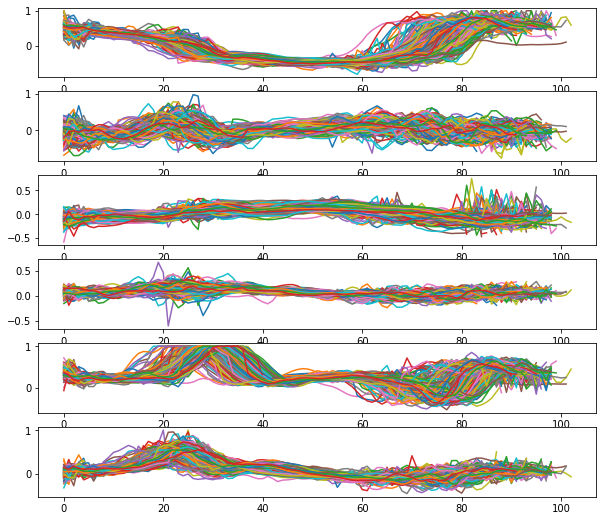

Touch feet
166.76923076923077
169.23076923076923
159.42857142857142
166.30769230769232
167.92857142857142
173.07142857142858
160.64285714285714
162.8
174.3846153846154
165.76923076923077
161.42857142857142
166.78571428571428
156.35714285714286
167.57142857142858
165.5
159.6153846153846


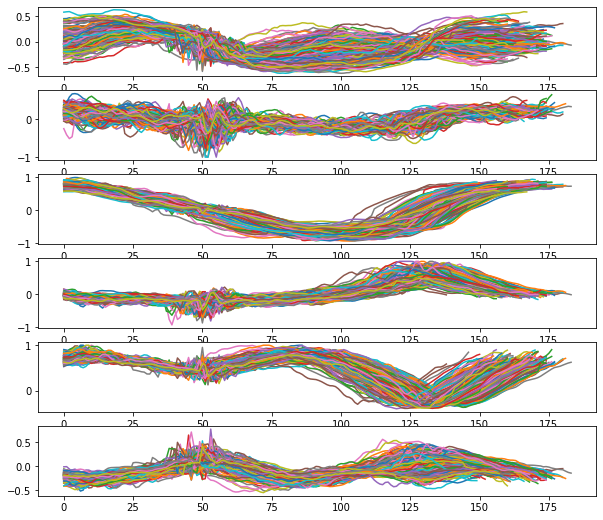

In [11]:
idxs = [[] for m in range(len(os.listdir(dir_)))]
movements_name = [[] for m in range(len(os.listdir(dir_)))]
samples = [[[] for n in range(n_axis)] for m in range(len(os.listdir(dir_)))]
data = [[] for m in movements_name]

plotOverlappingSamples = True


for m, movement in enumerate(os.listdir(dir_)):

    if plotOverlappingSamples:
        fig = plt.figure(figsize=(10, 9))
        axs = []
        for a in range(6):
            axs.append(fig.add_subplot(6, 1 , a+1))
    
    
    print(movement)
    movements_name[m] = movement
    
    movement_path = os.path.join(dir_, movement)
    
    n_trials = len(os.listdir(movement_path))
    
    idxs[m] = [[] for n in range(n_trials)]

    if 'Jumping' in movement:
        is_sin_like_axis = 0
        n_filters = 1
    elif 'Torso' in movement:
        is_sin_like_axis = 2
        n_filters = 1
    elif 'Running' in movement:
        is_sin_like_axis = 2
        n_filters = 1
    elif 'Touch' in movement:
        is_sin_like_axis = 2
        n_filters = 1
    else:
        print(movement)

    for tri, trial in enumerate(sorted(os.listdir(movement_path))):


        #[gx, gy, gz, ax, ay, az, t], _ = load_trial(os.path.join(movement_path, trial))
        [gx, gy, gz, ax, ay, az, dt] = load_trial(os.path.join(movement_path, trial))


        
        sensors_axis = [gx, gy, gz, ax, ay, az]
        sensors_axis = normalize_axis(sensors_axis)

        # is_sin_like_axis = index of axis in sensor_axis (0 : g_x, 1 : g_y, ..., 5 : a_z)
        # n_filters : number of times axis is filtered                
        

        #fig = plt.figure(figsize=(30, 20))
        #axs = []

        

        init_th = .3
        init = 0
        for i, val in enumerate(sensors_axis[is_sin_like_axis]):
            if val > init_th:
                init = i
                break
            
        _axis = [[] for a in range(len(sensors_axis))]
        for a,_ in enumerate(sensors_axis):
            _axis[a] = sensors_axis[a][init:]

        #for a, axis in enumerate(_axis):
        #    axs.append(fig.add_subplot(6, 1 , a+1))
        #    axs[-1].plot(np.arange(len(axis)), axis)
        
        filtered = savgol_filter(_axis[is_sin_like_axis], 51, 3)
        
        
        for n in range(n_filters):
            filtered = savgol_filter(filtered, 51, 3)

        #axs[is_sin_like_axis].plot(np.arange(len(filtered)), filtered)
        
        peaks = find_peaks(filtered, height=0)[0][1:-2]
        #diffs = [peaks[p+1]-peak for p, peak in enumerate(peaks[:-1])]
        #for p in peaks:
        #    axs[is_sin_like_axis].axvline(x=p, lw=0.75, c='black')

        #plt.show()


        
        #for p, peak in enumerate(peaks[2:-2]):
        #    idxs[m][t].append((peak, peaks[p+2]))
        
        avg_peak_dst = sum([peaks[p+1]-peak for p,peak in enumerate(peaks[:-1])])/(len(peaks)-1)
        print(avg_peak_dst)

        for p, peak in enumerate(peaks[:-1]):
            for a, axis in enumerate(_axis):
                if peaks[p+1]-peak>0.85*avg_peak_dst and peaks[p+1]-peak<1.15*avg_peak_dst: 

                    sample = np.array(axis[peak:peaks[p+1]])
                    samples[m][a].append(sample)
                    
                    if plotOverlappingSamples:
                        axs[a].plot(np.arange(len(sample)), sample)
                        
    if plotOverlappingSamples:
        plt.show()
        
        

In [12]:
for m,movement in enumerate(movements_name):
    print(f'Movement {movement} has {len(samples[m][0])} samples')

Movement Running in place has 229 samples
Movement Torso rotation has 254 samples
Movement Jumping jacks has 224 samples
Movement Touch feet has 219 samples


In [15]:
sensors = {'Gyroscope':[0,1,2], 'Accelerometer':[3,4,5]}
axis = {0:'x', 3:'x',1:'y', 4:'y',2:'z', 5:'z'}

Define the network using Brian2
We'll set three variables x,y,z, for each sensor, that correspond to the acquired sensor readings values
We set the values for one sample, then append a resting period where the network doesnt consider the input values (to reset network variables)

In [16]:
net = Network()

In [20]:
nu = Nube(N_per_edge)
N_i = nu.n

#The input starts with a resting period
resting_array = [0.0 for _ in range(int(resting_time/(1/sampling_frequency)))]


#We'll save networks components in dictionaries, to access by sensor type

Input = {}
InputSpikeMonitor = {}
InputStateMonitor = {}
InputMonitor = {}
InputRateMonitor = {}
Synapse = {}



pattern_dt = 1/sampling_frequency
elapsed_time=0*ms
x = {sensor : [] for sensor in sensors}
y = {sensor : [] for sensor in sensors}
z = {sensor : [] for sensor in sensors}


begins = []
durations = []
movement_index = []

iteration = []
it = 1

iteration_begin = []

movement_it = []

learning = []

events = [0,1,2,3,4,5]
event_type = {sensor: [] for sensor in sensors}



In [ ]:


for n in range(n_reps_per_sample):
    for sp in range(n_samples):
        for m,movement in enumerate(movements_name):
            for s,sensor in enumerate(sensors):
                
                axis_x = sensors[sensor][0]
                axis_y = sensors[sensor][1]
                axis_z = sensors[sensor][2]

                x[sensor].extend(samples[m][axis_x][sp])
                x[sensor].extend([x[sensor][-1] for r in range(len(resting_array))])

                y[sensor].extend(samples[m][axis_y][sp])
                y[sensor].extend([y[sensor][-1] for r in range(len(resting_array))])

                z[sensor].extend(samples[m][axis_z][sp])
                z[sensor].extend([z[sensor][-1] for r in range(len(resting_array))])




            sample_duration = len(samples[m][axis_x][sp])
            
            learning.extend([1.0 for _ in range(int(sample_duration))])
            learning.extend([-1 for _ in range(len(resting_array))])

            iteration_begin.extend([elapsed_time for _ in range(int(sample_duration))])
            iteration_begin.extend(resting_array)

            movement_it.extend([m for _ in range(int(sample_duration))])
            movement_it.extend([m for _ in range(len(resting_array))])

            begins.append(elapsed_time)
            durations.append(sample_duration*pattern_dt)
            movement_index.append(m)

            elapsed_time += sample_duration * pattern_dt + resting_time

        

        it += 1

    is_learning = TimedArray(learning, dt=pattern_dt)   #1 when input corresponds to sample, 0 otherwise





In [21]:
x_sensor_0 = TimedArray(x['Gyroscope'], dt=(1/sampling_frequency)) 
y_sensor_0 = TimedArray(y['Gyroscope'], dt=(1/sampling_frequency))
z_sensor_0 = TimedArray(z['Gyroscope'], dt=(1/sampling_frequency))

x_sensor_1 = TimedArray(x['Accelerometer'], dt=(1/sampling_frequency))
y_sensor_1 = TimedArray(y['Accelerometer'], dt=(1/sampling_frequency))
z_sensor_1 = TimedArray(z['Accelerometer'], dt=(1/sampling_frequency))


In [22]:
movement_duration = [0 for m in movements_name]
for m,movement in enumerate(movements_name):        
    movement_duration[m] = len(samples[m][0])*pattern_dt

In [23]:
##INPUT
#
#The input layer has N_per_edge^3 neurons, for each sensor (each sensor has 3 dimensions x,y,z)
#These neurons are uniformly distributed inside a cubic space
#Each neuron is attributed with a different 3d coordinate
#All neurons share a time dependent 3d coordinate (x_t, y_x, z_t) that corresponds to sensor readings
#If neurons are spatially close enough to the input readings (that is in_zone=True) they will fire 
#according to a Poisson rate process with a zone_fire Hz frequency. They can also fire according to 
#a Poisson rate process with a min_fire Hz frequency.

for s, sensor in enumerate(sensors):
    
    Input[sensor] = NeuronGroup(N_i, 
                                    '''
                                    zone_fire : Hz
                                    min_fire = 0.05*Hz : Hz
                                    x : 1   (constant)
                                    y : 1   (constant)
                                    z : 1   (constant)
                                    x_t = x_sensor_''' +str(s)+ '''(t) : 1 (shared)
                                    y_t = y_sensor_''' +str(s)+ '''(t) : 1 (shared)
                                    z_t = z_sensor_''' +str(s)+ '''(t) : 1 (shared)
                                    er = (abs(x_t-x)/2) + (abs(y_t-y)/2) + (abs(z_t-z)/2) : 1
                                    in_zone = er <= in_zone_d*sqrt(3) : boolean   (constant over dt)
                                    ''',
                                    threshold='(rand()<min_fire*dt or (in_zone and rand()<zone_fire*dt)) and is_learning(t)==1',
                                    refractory=refract_in,
                                    method='euler')


    Input[sensor].x = nu.x
    Input[sensor].y = nu.y
    Input[sensor].z = nu.z
    
    Input[sensor].zone_fire = in_rate

    net.add(Input[sensor])
    
    InputSpikeMonitor[sensor] = SpikeMonitor(Input[sensor])
    net.add(InputSpikeMonitor[sensor])

In [25]:
##WTA neurons

neurons = {}
NeuronsSpikeMonitor = {}
NeuronsStateMonitor = {}
NeuronsRateMonitor = {}
inhibition = {}
inhibition_0 = {}

#WTA neuron model
neuron_eqs = '''
dv/dt = ((V_rest-v) + R_m*I_m - R_i*I_i)/tau_m : volt (unless refractory)
dI_m/dt = -I_m/tau_I_m : amp
dI_i/dt = -I_i/tau_I_i : amp
dvt/dt = (Vth-vt)/tauvt : volt
inhibited : boolean
Vth : volt
'''
#WTA neuron reset operations
reset = '''
vt = v + d_vt
v=V_reset
I_m = 0*amp
'''




for s,sensor in enumerate(sensors):

    # A population of WTA neurons is set for each sensor
    neurons[sensor] = NeuronGroup(N_o, model=neuron_eqs,
                        threshold='v>vt and not(inhibited)', reset=reset,
                        refractory='tau_r', method='euler')

    # Random initial membrane potential values and conductances
    neurons[sensor].v = 'V_rest'
    neurons[sensor].vt = V_th[sensor]
    neurons[sensor].Vth = V_th[sensor]

    neurons[sensor].I_m = '0*amp'
    neurons[sensor].I_i = '0*amp'
    neurons[sensor].inhibited = False


    #This allows to reset the membrane potential without waiting for it to decay 
    #(smaller resting period following sample presentation) shortening the simulation time
    neurons[sensor].run_regularly('v = v*int(is_learning(t)==1) + V_rest*int(not(is_learning(t)==1))', dt=pattern_dt)
    neurons[sensor].run_regularly('vt = vt*int(is_learning(t)==1) + Vth*int(not(is_learning(t)==1))', dt=pattern_dt)

    net.add(neurons[sensor])

    NeuronsSpikeMonitor[sensor] = SpikeMonitor(neurons[sensor])
    net.add(NeuronsSpikeMonitor[sensor])

    if include_state_monitor['Neurons']:

        NeuronsStateMonitor[sensor] = StateMonitor(neurons[sensor], ['v', 'I_m', 'vt'], record=np.arange(N_o),dt=0.05*ms)
        net.add(NeuronsStateMonitor[sensor])
        NeuronsRateMonitor[sensor] = PopulationRateMonitor(neurons[sensor])
        net.add(NeuronsRateMonitor[sensor])

    
    ##WTA neurons share lateral inhibitory connections
    #We could set a third delayed operation 'inhibited_post = False' and just use one synapse
    #inhibition : if a wta neuron fires, it inhibits all the others
    #inhibition_0 (delayed by tau_inh): after have inhibited all the other neurons, it derestricts them after tau_inh
    inhibition[sensor] = Synapses(neurons[sensor], neurons[sensor], 
                                on_pre='''I_i_post = clip(I_i_post + w_i, 0*amp, I_i_post + w_i)
                                        inhibited_post = True''')
    inhibition_0[sensor] = Synapses(neurons[sensor], neurons[sensor], 
                                    on_pre='inhibited_post = False')

    inhibition[sensor].connect('i!=j')
    inhibition_0[sensor].connect('i!=j')
    inhibition_0[sensor].delay = tau_inh

    net.add(inhibition[sensor])
    net.add(inhibition_0[sensor])

WARNING    "i" is an internal variable of group "synapses", but also exists in the run namespace with the value 347. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_1", but also exists in the run namespace with the value 347. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_2", but also exists in the run namespace with the value 347. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_3", but also exists in the run namespace with the value 347. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [27]:
##
##  From https://brian.discourse.group/t/how-to-reset-network-monitors/548/15
##  Periodically stores the weights in weights_Accelerometer.txt and weights_Gyroscope.txt
##

@implementation('cpp','''
// Note that functions always need a return value at the moment
double store_weights_Gyroscope(double w, double t) {
    static std::ofstream weight_file("weights_Gyroscope.txt");  // opens the file the first time
    static double _prev_t = -1.;
    // Store all values for the same time in a line
    if (_prev_t != t) {
        if (_prev_t != -1.)
            weight_file << std::endl;
        weight_file << t << " ";
        _prev_t = t;
    }
    weight_file << w << " ";
    return 0.;  // unused
}
''')



@check_units(w=1, t=second, result=1)
def store_weights_Gyroscope(w, t):
    raise NotImplementedError('Use standalone mode')

@implementation('cpp','''
// Note that functions always need a return value at the moment
double store_weights_Accelerometer(double w, double t) {
    static std::ofstream weight_file("weights_Accelerometer.txt");  // opens the file the first time
    static double _prev_t = -1.;
    // Store all values for the same time in a line
    if (_prev_t != t) {
        if (_prev_t != -1.)
            weight_file << std::endl;
        weight_file << t << " ";
        _prev_t = t;
    }
    weight_file << w << " ";
    return 0.;  // unused
}
''')



@check_units(w=1, t=second, result=1)
def store_weights_Accelerometer(w, t):
    raise NotImplementedError('Use standalone mode')

In [28]:
## INPUT --> WTA 
## Synapses with trace-based STDP

InputNeuronsSynapse = {}
InputNeuronsSynapseMonitor = {}



for s,sensor in enumerate(sensors):
        
    InputNeuronsSynapse[sensor] = Synapses(Input[sensor], neurons[sensor],  '''
                            w : 1
                            dapre/dt = -apre/taupre : 1 (event-driven)
                            dapost/dt = -apost/taupost : 1 (event-driven)
                            ''',
                            on_pre = ''' I_m_post = I_m_post + w*w_e*(not_refractory_post)*int(not(inhibited_post))
                                apre += Apre
                                w = clip(w + apost, 0, wmax)
                            ''',
                            on_post='''                            
                                apost += Apost
                                w = clip(w + apre, 0, wmax)
                            ''')

    InputNeuronsSynapse[sensor].connect()
    InputNeuronsSynapse[sensor].w = 'wmax*initial_weight_coef*rand()'
    InputNeuronsSynapse[sensor].run_regularly('dummy_value = store_weights_'+sensor+'(w, t)', dt=5*second)
    net.add(InputNeuronsSynapse[sensor])


    if include_state_monitor['Synapses']:
        InputNeuronsSynapseMonitor[sensor] = StateMonitor(InputNeuronsSynapse[sensor], ['w'], record=np.arange(N_i*N_o), dt=20*second)
        net.add(InputNeuronsSynapseMonitor[sensor])
    


In [30]:
elapsed_time

0.81385 * ksecond

In [31]:
net.run(elapsed_time)
compile_duration = time.time()
device.build(directory=training_foldername, compile=True, run=True, debug=False, clean=True)
compile_duration = time.time() - compile_duration
print("compile_duration", compile_duration)

compile_duration 3243.1770277023315
